In [1]:
import cv2
import mediapipe as mp
import time
import math

class HandDetector:
    
    def __init__(self,mode = False,maxHands = 2, complexity = 1, detectionCon = 0.5,trackCon = 0.5):
        
        self.mode = mode
        self.maxHands = maxHands
        self.complexity = complexity
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        
        self.mpDraw = mp.solutions.drawing_utils
        self.mpHand = mp.solutions.hands
        
        self.Hands = self.mpHand.Hands(self.mode,self.maxHands,self.complexity,
                                       self.detectionCon,self.trackCon)
        
        self.tipIds = [4,8,12,16,20]
        
    def findHands(self,image, draw = True,flipType = True):
        
        imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.results = self.Hands.process(imageRGB)
        allHands = []
        h,w,c = image.shape
        
        if self.results.multi_hand_landmarks:
            for handType,handLms in zip(self.results.multi_handedness,self.results.multi_hand_landmarks):
                myHand = {}
                mylmList = []
                xList = []
                yList = []
                
                for id,lm in enumerate(handLms.landmark):
                    px,py,pz = int(lm.x*w),int(lm.y*h),int(lm.z*w)
                    mylmList.append([px,py,pz])
                    xList.append(px)
                    yList.append(py)
                    
                xmin,xmax = min(xList),max(xList) 
                ymin,ymax = min(yList),max(yList)
                
                bboxW,bboxH = xmax-xmin,ymax-ymin
                bbox = xmin,ymin,xmax,ymax
                
                cx,cy = bbox[0] + (bboxW // 2),bbox[1] + (bboxH // 2)
                
                myHand["lmList"] = mylmList
                myHand["bbox"] = bbox
                myHand["center"] = (cx,cy)
                
                if flipType:
                    if handType.classification[0].label == "Right":
                        myHand["type"] = "Left"
                    else:
                        myHand["type"] = "Right"
                        
                else:
                    
                    myHand["type"] = handType.classification[0].label
                    
                allHands.append(myHand)
                
                if draw:
                    
                    self.mpDraw.draw_landmarks(image,handLms,self.mpHand.HAND_CONNECTIONS)
                    
                    cv2.rectangle(image,(bbox[0]-20,bbox[1] - 20),(bbox[2]+20,bbox[3] + 20),
                                 (255,0,255),2)
                    
                    cv2.putText(image,myHand["type"],(bbox[0]-30,bbox[1] -30),cv2.FONT_HERSHEY_PLAIN,
                               2,(255,0,255),2)
                    
        if draw:
            return allHands,image
        
        else:
            return allHands
        
        
    def fingersUp(self,myHand,flipType=True):
            
        myHandType = myHand["type"]
        mylmList = myHand["lmList"]
        fingers = []
        if flipType :
            if myHandType == "Right":

                if mylmList[self.tipIds[0]][0] > mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)

            else:

                if mylmList[self.tipIds[0]][0] < mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)
                    
        else:
            if myHandType == "Right":

                if mylmList[self.tipIds[0]][0] < mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)

            else:

                if mylmList[self.tipIds[0]][0] > mylmList[self.tipIds[0] - 1][0]:
                    fingers.append(1)
                else:
                    fingers.append(0)
                    
            

        for id in range(1,5):
            if mylmList[self.tipIds[id]][1] < mylmList[self.tipIds[id] - 2][1]:
                fingers.append(1)
            else:
                fingers.append(0)

        return fingers
        
        
    def findDistance(self,p1,p2,image = None):
            
        x1,y1 = p1
        x2,y2 = p2
        cx,cy =( x1 + x2 ) // 2,(y1 + y2) // 2
        length = math.hypot(x2-x1,y2-y1)
        info = (x1,y1,x2,y2,cx,cy)

        if image is not None:

            cv2.circle(image, (x1,y1),15,(255,0,255),cv2.FILLED)
            cv2.circle(image, (x2,y2),15,(255,0,255),cv2.FILLED)
            cv2.line(image, (x1,y1),(x2,y2),(255,0,255),3)
            cv2.circle(image, (cx,cy),15,(255,0,255),cv2.FILLED)
            return length,info,image

        return length,info

In [10]:
import cv2

pTime = 0
def fps():
    
    global pTime 
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps

    
    
cap = cv2.VideoCapture(0)
cap.set(3,1280)
cap.set(4,720)

hand_detector = HandDetector(detectionCon=0.85,maxHands=1)
colorR = (255,0,255)

cx,cy,w,h = 100,100,200,200

    
while True:
    
    conn, frame = cap.read()
    frame = cv2.flip(frame,1)
    
    
    allHands, frame = hand_detector.findHands(frame,draw = True, flipType = False)
        
    if allHands:
        
        hands1 = allHands[0]
        lmList1 = hands1["lmList"]
        center1 = hands1["center"]
        bbox1 = hands1["bbox"]
        type1 = hands1["type"]
        
        length,info,frame = hand_detector.findDistance(lmList1[8][:-1],lmList1[12][:-1],frame)
        
        if length < 30:
            
            cursor = lmList1[8][:-1]
            # Şartı sağladğı an cursor yenileniyor !!!
            # Yukarıda bunları belirlemiştik önceden !!!
            if cx - w // 2 < cursor[0]< cx+w // 2 and cy-h // 2< cursor[1]< cy+h // 2:
                colorR = (0,255,0)
                # 300,400 olsun yenisi
                # x,y = 200,200 zaten
                # 300 - 200 // 2 -- > 200, 300 + 200 // 2 --> 400
                # 400 - 200 // 2 --> 300, 400 + 200 // 2 -- > 500
                # Sonuç zaten 200,200 bir kare yine !!!
                # Her türlü uzunluğunu ve genişliğini koruyor !!! 
                cx,cy = cursor

            else:
                colorR = (255,0,255)
        
    # Bölme kuralı uygunlanıyor !!!
    # cx,cy,w,h = 100,100,200,200 örneği için !!!
    # 0, 0, 200 , 200 sonuçları sırasıyla !!!
    cv2.rectangle(frame,(cx-w // 2, cy-h//2),(cx+w // 2, cy+h//2),colorR,cv2.FILLED)
    #print(cx-w // 2, cy-h//2,cx+w // 2, cy+h//2)
        
    
    
    fps_ = fps()
    cv2.putText(frame,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Frame",frame)
    if cv2.waitKey(1) & 0xff == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()

In [11]:
import cv2
import numpy as np

pTime = 0
def fps():
    
    global pTime 
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps
 
cap = cv2.VideoCapture(0)
cap.set(3,1280)
cap.set(4,720)

hand_detector = HandDetector(detectionCon=0.85,maxHands=1)
colorR = (255,0,255)


class DrawRect:
    def __init__(self,posCenter,size = [200,200]):
        self.posCenter = posCenter
        self.size = size
        
    def update(self,cursor):
        cx,cy = self.posCenter
        w,h = self.size
        
        # If the index finger tip is in the rectangle region
        if cx-w//2 < cursor[0] < cx+w//2 and cy-h // 2 < cursor[1] < cy+h //2 :
            self.posCenter = cursor
            
def corner_line(image,l = 30):
    
        cv2.line(image,(cx-w // 2, cy-h//2),(cx-w // 2, cy-h//2 + l),(0,255,0),3)
        cv2.line(image,(cx-w // 2, cy-h//2),(cx-w // 2 + l, cy-h//2 ),(0,255,0),3)
        
        cv2.line(image,(cx+w // 2, cy+h//2),(cx+w // 2, cy+h//2 - l),(0,255,0),3)
        cv2.line(image,(cx+w // 2, cy+h//2),(cx+w // 2 - l, cy+h//2 ),(0,255,0),3)
        
        cv2.line(image,(cx-w // 2, cy+h//2),(cx-w // 2, cy+h//2 - l),(0,255,0),3)
        cv2.line(image,(cx-w // 2, cy+h//2),(cx-w // 2 + l, cy+h//2 ),(0,255,0),3)
        
        cv2.line(image,(cx+w // 2, cy-h//2),(cx+w // 2, cy-h//2 + l),(0,255,0),3)
        cv2.line(image,(cx+w // 2, cy-h//2),(cx+w // 2 - l, cy-h//2 ),(0,255,0),3)

rectList = []
for x in range(5):
    # x değerini çarptık çünkü aynı x ekseninde olmasını istemiyoruz !!!
    rectList.append(DrawRect(posCenter=[x*250+150,150]))

while True:
    
    conn, frame = cap.read()
    frame = cv2.flip(frame,1)
        
    allHands, frame = hand_detector.findHands(frame,draw = True, flipType = False)
        
    if allHands:
        
        hands1 = allHands[0]
        lmList1 = hands1["lmList"]
        center1 = hands1["center"]
        bbox1 = hands1["bbox"]
        type1 = hands1["type"]
        
        length,info,frame = hand_detector.findDistance(lmList1[8][:-1],lmList1[12][:-1],frame)
        
        if length < 30:
            cursor = lmList1[8][:-1]
            for rect in rectList:
                rect.update(cursor)
    
    frameNew = np.zeros_like(frame,np.uint8)
    
    for rect in rectList:
        cx,cy = rect.posCenter
        w, h = rect.size
        cv2.rectangle(frameNew,(cx-w // 2, cy-h//2),(cx+w // 2, cy+h//2),colorR,cv2.FILLED)
        corner_line(frameNew,l=30)
        
    out = frame.copy()
    alpha = 0.5
    mask = frameNew.astype(bool)
    out[mask] = cv2.addWeighted(frame,alpha,frameNew,1-alpha,0)[mask]
     
    fps_ = fps()
    cv2.putText(out,f"FPS : {int(fps_)}",(20,70),cv2.FONT_HERSHEY_PLAIN,3,(255,0,0),3)
    cv2.imshow("Frame",out)
    if cv2.waitKey(1) & 0xff == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()

## 

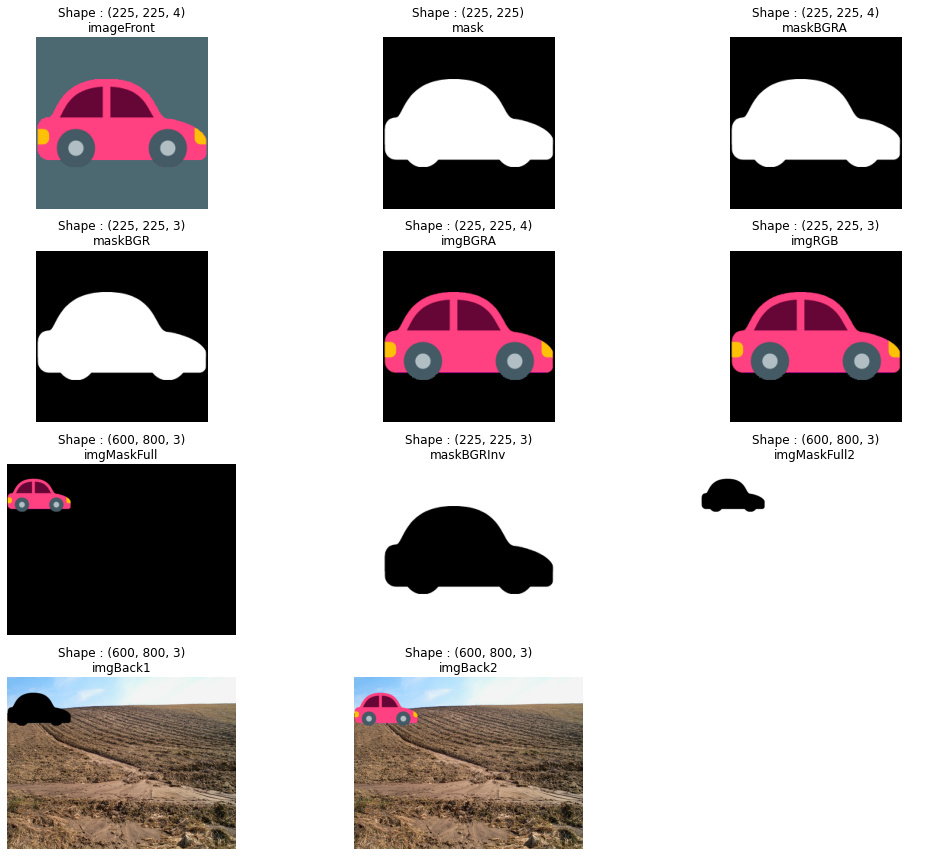

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display_image(image):  
    plt.figure(figsize = (5,5))
    plt.imshow(image)
    plt.title(f"Shape : {image.shape}")
    plt.axis("off")
    plt.show()
    
def convert_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def overlayPNG(imgBack,imgFront,pos = [0,0]):
    
    hf,wf,cf = imgFront.shape
    hb,wb,cb = imgBack.shape
    *_,mask = cv2.split(imgFront)
    maskBGRA = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGRA)
    maskBGR = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    imgRGBA = cv2.bitwise_and(imgFront,maskBGRA) 
    imgRGB = cv2.cvtColor(imgRGBA,cv2.COLOR_BGRA2BGR)
    
    imgMaskFull = np.zeros((hb,wb,cb),np.uint8)
    imgMaskFull[pos[1]:hf + pos[1], pos[0]:wf + pos[0],:] = imgRGB
    imgMaskFull2 = np.ones((hb,wb,cb),np.uint8) * 255
    maskBGRInv = cv2.bitwise_not(maskBGR)
    imgMaskFull2[pos[1]:hf + pos[1], pos[0]:wf + pos[0],:] = maskBGRInv
    
    imgBack = cv2.bitwise_and(imgBack,imgMaskFull2)
    imgBack = cv2.bitwise_or(imgBack,imgMaskFull)
    return imgBack
    
path1 = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/DropAndDrag/ImagesPNG/1.png"  
path2 = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/land.png"

imageBack = cv2.imread(path2)
imageFront = cv2.imread(path1,cv2.IMREAD_UNCHANGED)

hf,wf,cf = imageFront.shape
hb,wb,cb = imageBack.shape

*_,mask = cv2.split(imageFront)

maskBGRA = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGRA)
maskBGR =  cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

imgRGBA= cv2.bitwise_and(imageFront,maskBGRA)
imgRGB = cv2.cvtColor(imgRGBA,cv2.COLOR_BGRA2BGR)

pos = [0,0]
imgMaskFull = np.zeros((hb,wb,cb),np.uint8)
imgMaskFull[pos[1]:hf + pos[1], pos[0]:wf + pos[0], :] = imgRGB
imgMaskFull2 = np.ones((hb,wb,cb),np.uint8) * 255
maskBGRInv = cv2.bitwise_not(maskBGR)
imgMaskFull2[pos[1]:hf + pos[1], pos[0]:wf + pos[0], :] = maskBGRInv

imgBack1 = cv2.bitwise_and(imageBack,imgMaskFull2) 
imgBack2 = cv2.bitwise_or(imgBack1,imgMaskFull)

liste = [imageFront,mask,maskBGRA,maskBGR,imgBGRA,imgRGB,imgMaskFull,maskBGRInv,imgMaskFull2,imgBack1,imgBack2]
liste_name = ["imageFront","mask","maskBGRA","maskBGR","imgBGRA","imgRGB","imgMaskFull","maskBGRInv",
             "imgMaskFull2","imgBack1","imgBack2"]

plt.figure(figsize = (15,12))
for i in range(len(liste)):
    
    plt.subplot(4,3,i+1)
    plt.imshow(convert_image(liste[i]),cmap = "gray")
    plt.title(f"Shape : {liste[i].shape}\n{liste_name[i]}")
    plt.axis("off")

plt.tight_layout()

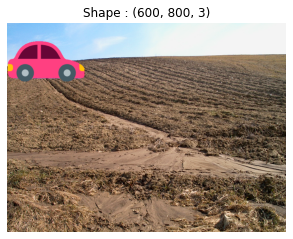

In [16]:
path1 = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/DropAndDrag/ImagesPNG/1.png"  
path2 = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/land.png"

imageBack = cv2.imread(path2)
imageFront = cv2.imread(path1,cv2.IMREAD_UNCHANGED)

display_image(convert_image(overlayPNG(imageBack,imageFront,pos = [0,0])))

In [38]:
import time
import cv2
import os

pTime = 0
def fps():
    global pTime
    cTime = time.time()
    fps = 1 / (cTime - pTime)
    pTime = cTime
    return fps
    
#path1 = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/DropAndDrag/ImagesJPG/1.jpg"   
#path2 = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/DropAndDrag/ImagesPNG/1.png"   
#image1 = cv2.imread(path1)
#image2 = cv2.imread(path2,cv2.IMREAD_UNCHANGED)

#h,w,_ = image1.shape
#ox,oy = 500,200    

cap = cv2.VideoCapture(0)
cap.set(3,1280)
cap.set(4,720)

hand_detector = HandDetector(detectionCon= 0.65)

class DragImg():
    def __init__(self,path,posOrigin,imageType):
 
        self.posOrigin = posOrigin 
        self.imageType = imageType
        self.path = path
        
        if self.imageType == "png":
            self.img = cv2.imread(self.path,cv2.IMREAD_UNCHANGED)
        else:
            self.img = cv2.imread(self.path)
            
        self.size = self.img.shape[:-1]
        
    def update(self,cursor):
        ox,oy = self.posOrigin
        h,w = self.size
        
        if ox < cursor[0] < ox + w and oy < cursor[1] < oy + h:
            self.posOrigin = cursor[0] - w // 2, cursor[1] - h // 2
        
              
MIX = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/DropAndDrag/ImagesMIX"
myList = os.listdir(MIX)
listImg = []

for x,pathImg in enumerate(myList):
    if "png" in pathImg:
        imageType = "png"
        print("png")
    else:
        imageType = "jpg"
        print("jpg")
        
    listImg.append(DragImg(f"{MIX}/{pathImg}",[x*300+50,100],imageType))
    
print(len(listImg))


while True:
    
    succes, frame = cap.read()
    frame = cv2.flip(frame,1)
    
    allHands,frame = hand_detector.findHands(frame,draw = True,flipType = False)
    
    if allHands:
        
        hands1 = allHands[0]
        lmLst = hands1["lmList"]
        fingers = hand_detector.fingersUp(hands1,flipType = False)

        #cursor = lmLst[8][:-1]
        length,info,frame = hand_detector.findDistance(lmLst[8][:-1],lmLst[12][:-1],frame)
        #print(length)
        if length < 60:
            cv2.putText(frame,f"MODE : Drop And Drap", (20,100), cv2.FONT_HERSHEY_PLAIN,2,(255,0,0),2)
            cursor = lmLst[8][:-1]
            #if ox < cursor[0] < ox+w and oy < cursor[1] < oy+h:
                #print("Inside Image")
                #ox,oy = cursor[0] - w // 2, cursor[1] - h // 2
            
            for imgObj in listImg:
                imgObj.update(cursor)
        
        
    try:
        for imgObj in listImg:
            h,w = imgObj.size
            ox,oy = imgObj.posOrigin
            if imgObj.imageType == "png":
                frame =overlayPNG(frame,imgObj.img,pos = [ox,oy])
            else:
                frame[oy : oy+h, ox : ox+w] = imgObj.img

        #frame =overlayPNG(frame,image2,pos = [ox,oy])
        #frame[oy:oy+h,ox:ox+w] = image1
    except:
        pass
    
    # Draw 
    fps_ = fps()
    cv2.putText(frame,f"FPS : {int(fps_)}", (20,70), cv2.FONT_HERSHEY_PLAIN,2,(255,0,0),2)
    cv2.imshow("Frame",frame)
    if cv2.waitKey(1) & 0xff == ord("q"):
        break

        
cap.release()        
cv2.destroyAllWindows()

png
png
jpg
jpg
4
